<a href="https://colab.research.google.com/github/singwang-cn/Neural-Network/blob/master/DCGANs_for_graduation_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
import scipy.signal
import cv2

In [ ]:
'''
https://github.com/cww97/cs231n/blob/master/assignment3/Generative_Adversarial_Networks_PyTorch.ipynb
'''

In [3]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

In [4]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST('./gtexp/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./gtexp/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
#show_images(imgs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./gtexp/datasets/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./gtexp/datasets/MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./gtexp/datasets/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./gtexp/datasets/MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./gtexp/datasets/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./gtexp/datasets/MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./gtexp/datasets/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./gtexp/datasets/MNIST_data/MNIST/raw



In [5]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    ans = torch.rand(batch_size, dim)
    ans = (ans - ans.mean()) / ans.var()
    return ans.uniform_(-1, 1)

In [6]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

In [7]:
dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

In [8]:
def build_dc_classifier():
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    """
    return nn.Sequential(
        Unflatten(batch_size, 1, 28, 28),
        nn.Conv2d(1, 32, 5, stride=1),
        nn.LeakyReLU(0.01),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(32, 64, 5, stride=1),
        nn.LeakyReLU(0.01),
        nn.MaxPool2d(2, stride=2),
        Flatten(),
        nn.Linear(4*4*64, 4*4*64),
        nn.LeakyReLU(0.01),
        nn.Linear(4*4*64, 1),
    )
'''
data = next(enumerate(loader_train))[-1][0].type(dtype)
b = build_dc_classifier().type(dtype)
out = b(data)
print(out.size())
'''

'\ndata = next(enumerate(loader_train))[-1][0].type(dtype)\nb = build_dc_classifier().type(dtype)\nout = b(data)\nprint(out.size())\n'

In [9]:
def build_dc_generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the DCGAN generator using
    the architecture described above.
    """
    return nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Linear(1024, 7*7*128),
        nn.ReLU(),
        nn.BatchNorm1d(7*7*128),
        Unflatten(-1, 128, 7, 7),
        nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1),
        nn.Tanh(),
        Flatten(),
    )
'''
test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()
'''

'\ntest_g_gan = build_dc_generator().type(dtype)\ntest_g_gan.apply(initialize_weights)\n\nfake_seed = torch.randn(batch_size, NOISE_DIM).type(dtype)\nfake_images = test_g_gan.forward(fake_seed)\nfake_images.size()\n'

In [10]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    labels_real = torch.ones_like(logits_real).type(dtype)
    labels_fake = torch.zeros_like(logits_fake).type(dtype)
    loss = bce_loss(logits_real, labels_real).mean() + \
           bce_loss(logits_fake, labels_fake).mean()
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    labels_fake = torch.ones_like(logits_fake).type(dtype)
    loss = bce_loss(logits_fake, labels_fake).mean()
    return loss

In [11]:
def compute_fid(real_imgs, fake_imgs):
  x = scale_images(ch1to3(real_imgs.detach().cpu().numpy().reshape(real_imgs.shape[0], real_imgs.shape[2], real_imgs.shape[3])), (299,299,3))
  y = scale_images(ch1to3(fake_imgs.detach().cpu().numpy().reshape(fake_imgs.shape[0], 28, 28)), (299,299,3))
  x = preprocess_input(x)
  y = preprocess_input(y)
  fid = calculate_fid(incv3, x, y)
  print('FID:', fid)

  return fid

In [12]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=96, num_epochs=10):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = x.type(dtype)
            logits_real = D(2* (real_data - 0.5)).type(dtype)

            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            # record loss
            d_loss_list.append(d_total_error)
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
            g_error = generator_loss(gen_logits_fake)
            # record loss
            g_loss_list.append(g_error)
            g_error.backward()
            G_solver.step()

            

            if (iter_count % show_every == 0):
                # record fid
                fid_list.append(compute_fid(x, fake_images))
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

In [13]:
def get_optimizer(model, lr=1e-3):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))
    return optimizer

64.5772209005346
Iter: 0, D: 1.385, G:0.7061


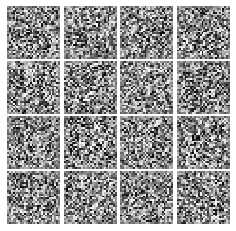


59.95629145286541
Iter: 250, D: 0.08082, G:3.749


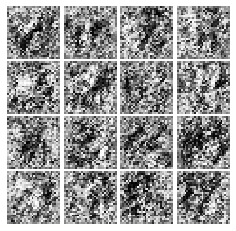


26.923927755543914
Iter: 500, D: 0.1186, G:4.009


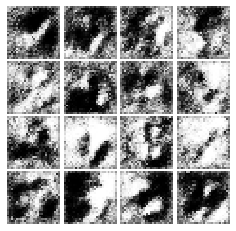


20.368526401969348
Iter: 750, D: 0.1584, G:4.86


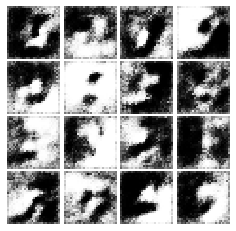


33.78491935191519
Iter: 1000, D: 0.2298, G:5.697


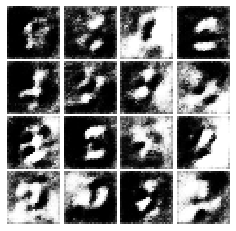


41.468950438718664
Iter: 1250, D: 0.2818, G:4.859


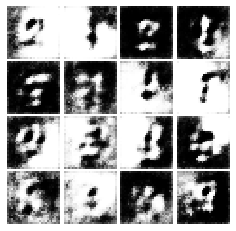


40.91866538994679
Iter: 1500, D: 0.2799, G:4.628


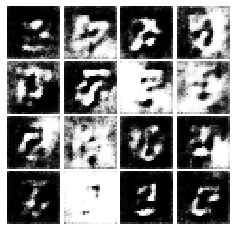


36.49488684589112
Iter: 1750, D: 0.2111, G:4.37


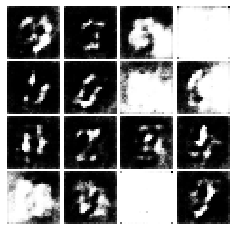


38.69417558636302
Iter: 2000, D: 0.2234, G:5.112


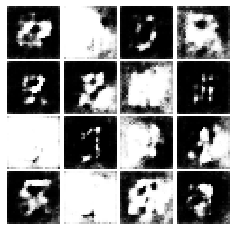


36.166710273365155
Iter: 2250, D: 0.2929, G:5.288


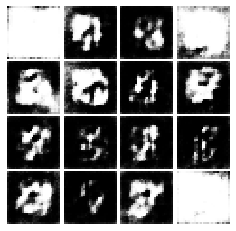


39.48201100149559
Iter: 2500, D: 0.2963, G:5.05


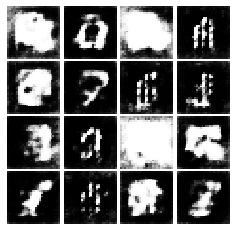


36.47259254385428
Iter: 2750, D: 0.3022, G:4.85


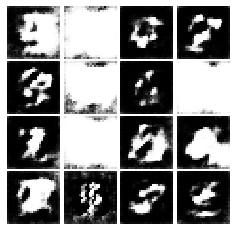


34.70939574959843
Iter: 3000, D: 0.3027, G:4.685


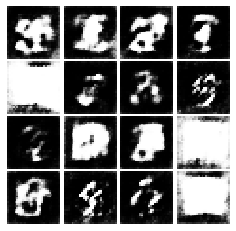


35.828836336795646
Iter: 3250, D: 0.2979, G:4.132


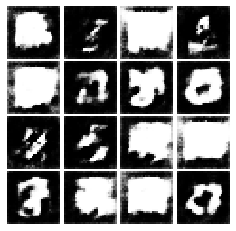


38.08862304630637
Iter: 3500, D: 0.307, G:3.775


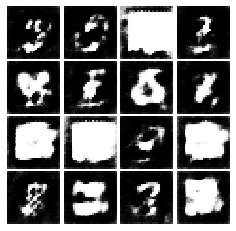


37.412737887840294
Iter: 3750, D: 0.3522, G:3.358


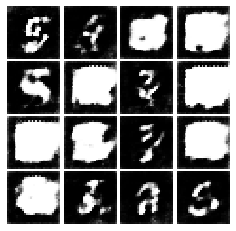


35.514294693297295
Iter: 4000, D: 0.3877, G:3.583


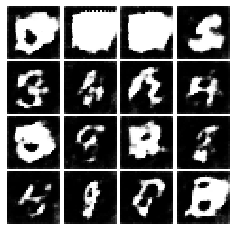


35.915953912894246
Iter: 4250, D: 0.3457, G:3.238


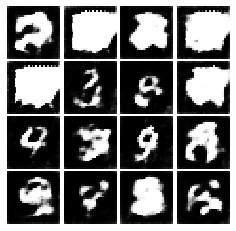


38.19813437294054
Iter: 4500, D: 0.3854, G:3.389


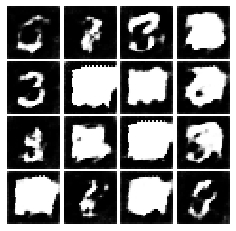


39.1522822127946
Iter: 4750, D: 0.3884, G:3.577


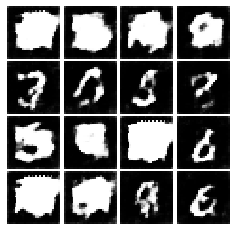


39.959577558936445
Iter: 5000, D: 0.3601, G:3.512


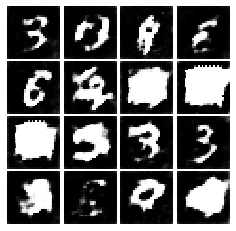


47.0501753533322
Iter: 5250, D: 0.5282, G:3.089


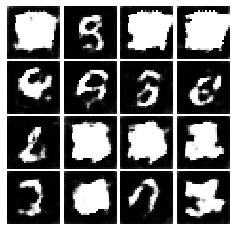


47.817181519062906
Iter: 5500, D: 0.3383, G:3.291


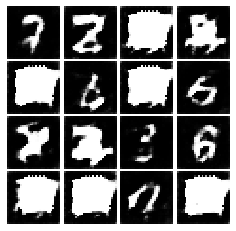


49.71557835107964
Iter: 5750, D: 0.6013, G:2.653


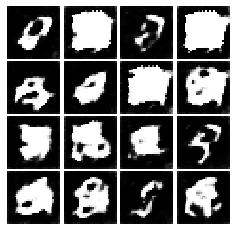


51.953268044839966
Iter: 6000, D: 0.6003, G:3.027


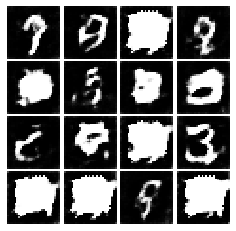


49.52115193917473
Iter: 6250, D: 1.022, G:2.297


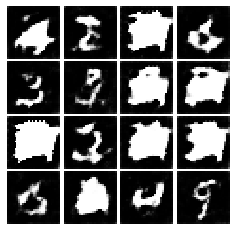


51.27987792357597
Iter: 6500, D: 0.415, G:3.452


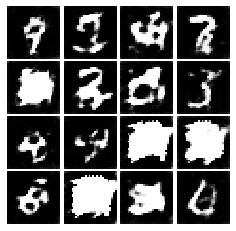


44.486984554976374
Iter: 6750, D: 0.4884, G:3.283


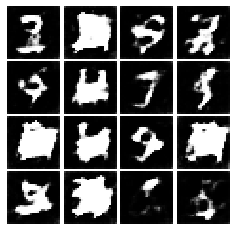


55.35695406658162
Iter: 7000, D: 0.558, G:2.939


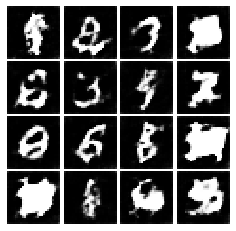


50.47576940514601
Iter: 7250, D: 0.5591, G:2.867


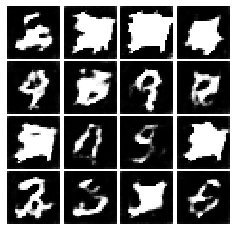


49.994009313648
Iter: 7500, D: 0.4262, G:2.797


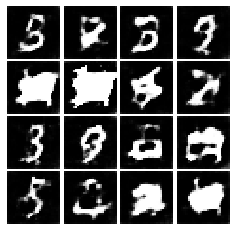


50.2555794531905
Iter: 7750, D: 0.449, G:2.945


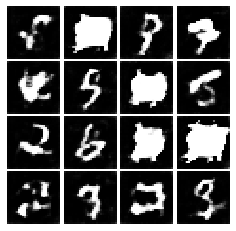

In [28]:
d_loss_list = []
g_loss_list = []
fid_list = []
incv3 = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

D_DC = build_dc_classifier().type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC, 1e-5)
G_DC_solver = get_optimizer(G_DC, 1e-5)

run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, num_epochs=20)

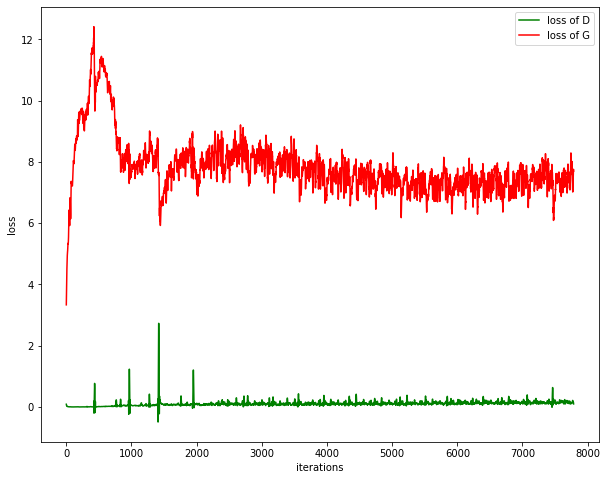

In [ ]:
plt.figure('Loss')
plt.plot(scipy.signal.savgol_filter(d_loss_list, 25, 5)[15:], 'g', label='loss of D')
plt.plot(scipy.signal.savgol_filter(g_loss_list, 25, 5)[15:], 'r', label='loss of G')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
#plt.savefig(fname='/content/drive/MyDrive/Colab Notebooks/TTURloss.png')

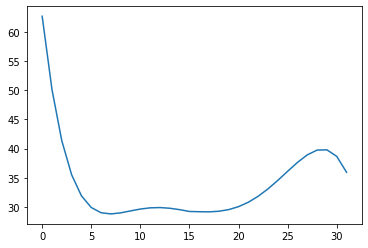

In [23]:
plt.figure('FID')
plt.plot(scipy.signal.savgol_filter(fid_list, 31, 5))

In [26]:
fid_list[-1]

71.78956529817965

In [14]:
def ch1to3(imgs):
  new_imgs = []
  for img in imgs:
    new_imgs.append(cv2.merge((img, img, img)))
  return np.array(new_imgs)

In [ ]:
original_img = ch1to3(mnist_train.data.numpy())
generated_img = ch1to3(G_DC(sample_noise(60000, 96).type(dtype)).detach().cpu().numpy().reshape(60000, 28, 28))

In [15]:
'''
https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/
'''
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = []
	for image in images:
		# resize with nearest neighbor interpolation
		images_list.append(resize(image, new_shape, 0))
	return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
# prepare the inception v3 model
incv3 = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# define two fake collections of images
images1 = randint(0, 255, 128*28*28*3)
images1 = images1.reshape((128,28,28,3))
images2 = randint(0, 255, 128*28*28*3)
images2 = images2.reshape((128,28,28,3))
print('Prepared', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')

# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

# fid between images1 and images1
fid = calculate_fid(incv3, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(incv3, images1, images2)
print('FID (different): %.3f' % fid)

87924736/87910968 [==============================] - 1s 0us/step
Prepared (128, 28, 28, 3) (128, 28, 28, 3)
Scaled (128, 299, 299, 3) (128, 299, 299, 3)
FID (same): -0.000
FID (different): 10.852
